HuggingFace Inference Server Demo

1. Testing Server Connectivity
------------------------------
Server is healthy!
Health status: {'status': 'healthy', 'loaded_models': 1, 'gpu_available': False}

2. Single Request Test
------------------------------
Testing with model: distilbert-base-uncased-finetuned-sst-2-english
Input: 'I love this product! It's amazing!'
Result: {
  "model_name": "distilbert-base-uncased-finetuned-sst-2-english",
  "outputs": [
    {
      "label": "POSITIVE",
      "score": 0.9998871088027954
    }
  ],
  "processing_time": 0.05367541313171387
}

3. Parallel Requests Processing
------------------------------
Completed request 1/10: The weather is nice today....
Completed request 2/10: This movie was disappointing....
Completed request 3/10: I love this product! It's amaz...
Completed request 4/10: I'm feeling great about this p...
Completed request 5/10: This is terrible, I hate it....
Completed request 6/10: Excellent customer service!...
Completed request 7/1

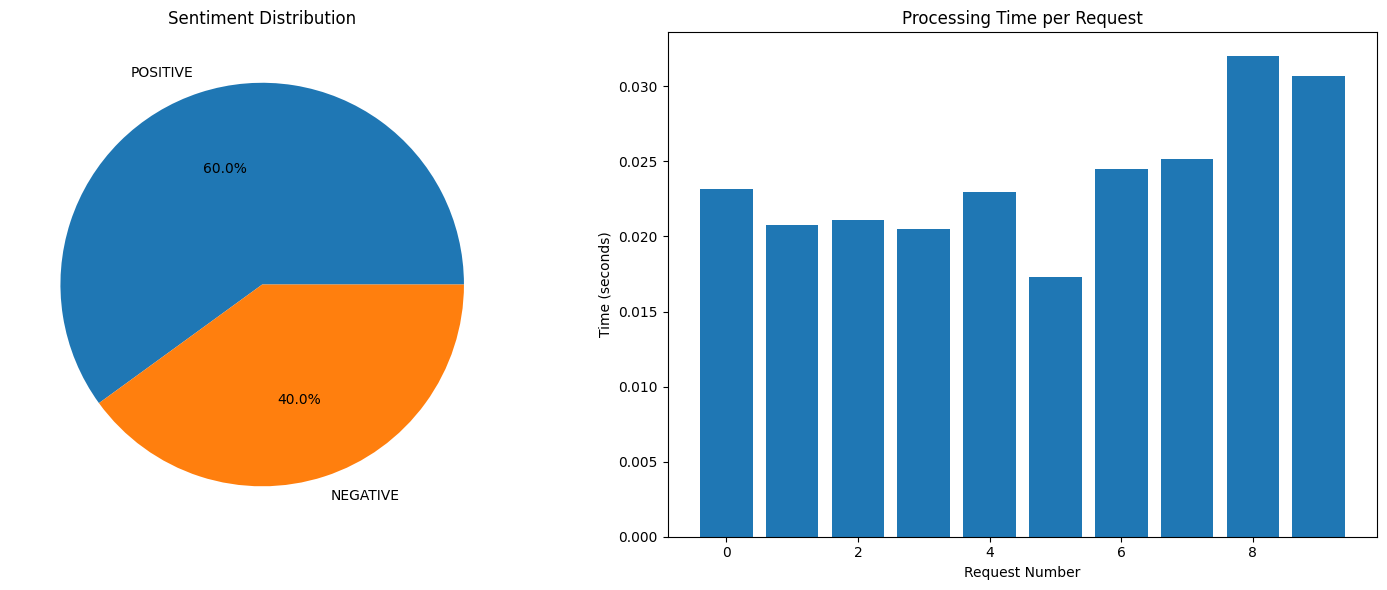


6. Server Statistics
------------------------------
Loaded models: ['distilbert-base-uncased-finetuned-sst-2-english']
Cache size: 1


In [3]:
import requests
import asyncio
import aiohttp
import time
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import pandas as pd

SERVER_URL = "http://localhost"
PREDICT_ENDPOINT = f"{SERVER_URL}/predict"

DEMO_MODEL = "distilbert-base-uncased-finetuned-sst-2-english"

print("HuggingFace Inference Server Demo")
print("=" * 50)

test_texts = [
    "I love this product! It's amazing!",
    "This is terrible, I hate it.",
    "The weather is nice today.",
    "I'm feeling great about this project.",
    "This movie was disappointing.",
    "Excellent customer service!",
    "The food was okay, nothing special.",
    "I'm so excited for the weekend!",
    "This is the worst experience ever.",
    "Pretty good overall, would recommend."
]

def make_single_request(text, model_name=DEMO_MODEL):
    payload = {
        "model_name": model_name,
        "inputs": text,
        "task": "sentiment-analysis"
    }
    
    try:
        response = requests.post(PREDICT_ENDPOINT, json=payload, timeout=30)
        return response.json()
    except Exception as e:
        return {"error": str(e), "text": text}

def test_server_health():
    try:
        response = requests.get(f"{SERVER_URL}/health", timeout=5)
        if response.status_code == 200:
            print("Server is healthy!")
            print(f"Health status: {response.json()}")
            return True
        else:
            print("Server health check failed")
            return False
    except Exception as e:
        print(f"Cannot connect to server: {e}")
        return False
print("\n1. Testing Server Connectivity")
print("-" * 30)
if not test_server_health():
    print("Please make sure the server is running with: docker-compose up")
    exit()

print("\n2. Single Request Test")
print("-" * 30)
print(f"Testing with model: {DEMO_MODEL}")
sample_text = test_texts[0]
print(f"Input: '{sample_text}'")

result = make_single_request(sample_text)
print(f"Result: {json.dumps(result, indent=2)}")

print("\n3. Parallel Requests Processing")
print("-" * 30)
start_time = time.time()
parallel_results = []

with ThreadPoolExecutor(max_workers=5) as executor:
    future_to_text = {
        executor.submit(make_single_request, text): text 
        for text in test_texts
    }
    
    completed_count = 0
    for future in as_completed(future_to_text):
        text = future_to_text[future]
        try:
            result = future.result()
            parallel_results.append((text, result))
            completed_count += 1
            print(f"Completed request {completed_count}/{len(test_texts)}: {text[:30]}...")
        except Exception as e:
            print(f"Request failed for '{text}': {e}")
            parallel_results.append((text, {"error": str(e)}))

parallel_time = time.time() - start_time
print(f"Parallel processing completed in {parallel_time:.2f} seconds")

print("\nParallel Processing Results:")
print("-" * 40)
for i, (text, result) in enumerate(parallel_results):
    if 'error' in result:
        print(f"{i+1}. Error for '{text[:50]}': {result['error']}")
    elif 'outputs' in result and result['outputs']:
        sentiment = result['outputs'][0]
        print(f"{i+1}. '{text}' → {sentiment['label']} ({sentiment['score']:.4f}) [{result.get('processing_time', 0):.3f}s]")
    else:
        print(f"{i+1}. Unexpected result for '{text[:50]}': {result}")

parallel_results_ordered = []
for original_text in test_texts:
    for stored_text, result in parallel_results:
        if stored_text == original_text:
            parallel_results_ordered.append(result)
            break
parallel_results = parallel_results_ordered

print("\n4. Performance Analysis")
print("-" * 30)
print(f" PERFORMANCE METRICS:")
print(f"   Total processing time: {parallel_time:.2f}s")
print(f"   Requests processed: {len(test_texts)}")
print(f"   Average time per request: {parallel_time/len(test_texts):.3f}s")
print(f"   Concurrent workers: 5")
print(f"   Throughput: {len(test_texts)/parallel_time:.1f} requests/second")

print(f"\n ALL RESULTS:")
print("=" * 70)
print(f"{'#':<3} {'Text':<35} {'Sentiment':<12} {'Confidence':<10}")
print("=" * 70)

for i, result in enumerate(parallel_results):
    text = test_texts[i][:32]
    
    if 'error' in result:
        print(f"{i+1:<3} {text:<35} {'ERROR':<12} {'N/A':<10}")
    elif 'outputs' in result and result['outputs']:
        sentiment = result['outputs'][0]
        confidence = f"{sentiment['score']:.4f}"
        print(f"{i+1:<3} {text:<35} {sentiment['label']:<12} {confidence:<10}")
    else:
        print(f"{i+1:<3} {text:<35} {'UNKNOWN':<12} {'N/A':<10}")

print("=" * 70)

print("\n5. Results Analysis")
print("-" * 30)

print("Sample results structure:")
for i, result in enumerate(parallel_results[:2]):
    print(f"Result {i+1}: {json.dumps(result, indent=2)}")

processed_results = []
for i, result in enumerate(parallel_results):
    if 'error' in result:
        print(f"Error for text '{test_texts[i]}': {result['error']}")
        continue
        
    if 'outputs' in result and result['outputs']:
        try:
            outputs = result['outputs']
            if isinstance(outputs, list) and len(outputs) > 0:
                sentiment = outputs[0]
                if isinstance(sentiment, dict) and 'label' in sentiment and 'score' in sentiment:
                    processed_results.append({
                        'text': test_texts[i],
                        'label': sentiment['label'],
                        'score': sentiment['score'],
                        'processing_time': result.get('processing_time', 0)
                    })
                else:
                    print(f"Unexpected output format for text {i}: {sentiment}")
            else:
                print(f"Empty or invalid outputs for text {i}: {outputs}")
        except Exception as e:
            print(f"Error processing result {i}: {e}")

print(f"\nSuccessfully processed {len(processed_results)} results")

if processed_results:
    df = pd.DataFrame(processed_results)
    print("\nProcessed Results:")
    print(df.to_string(index=False))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    if 'label' in df.columns:
        sentiment_counts = df['label'].value_counts()
        ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        ax1.set_title('Sentiment Distribution')
    else:
        ax1.text(0.5, 0.5, 'No sentiment data available', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Sentiment Distribution - No Data')

    if 'processing_time' in df.columns:
        ax2.bar(range(len(df)), df['processing_time'])
        ax2.set_title('Processing Time per Request')
        ax2.set_xlabel('Request Number')
        ax2.set_ylabel('Time (seconds)')
    else:
        ax2.text(0.5, 0.5, 'No timing data available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Processing Times - No Data')

    plt.tight_layout()
    plt.show()
else:
    print(" No results were successfully processed. Check server responses above.")

print("\n6. Server Statistics")
print("-" * 30)
try:
    models_response = requests.get(f"{SERVER_URL}/models")
    models_info = models_response.json()
    print(f"Loaded models: {models_info['loaded_models']}")
    print(f"Cache size: {models_info['cache_size']}")
except Exception as e:
    print(f"Could not get server statistics: {e}")
